By design, this boosting technique uses decision trees as an underlying principle.

The main idea is to aggregate several iteratively created models, but also to give each of them a different weight.

The following approach explains the reasoning used in the design of a GBT:

Take random weights (weights  𝑤𝑖
 ) for weak classifiers (parameters  𝑎𝑖
 ) and form a final classifier.
Calculate the error induced by this final classifier, and search for the weak classifier that comes closest to this error.
Remove this weak classifier from the final classifier, while optimizing its weight with respect to a loss function.
Repeat the process iteratively.


The gradient boosting procedure therefore consists in finding the weights that optimize the cost function relative to the classification problem.
This involves exploring a space of simple functions by gradient descent.

XGBoost uses a variation of gradient descent called functional gradient descent, since we're working in a functional space when we talk about the classifiers in the boosting algorithm.

The gradient of the loss function is used to calculate the individual weights when building each new model.

XGBoost lets you save the matrices or models you've built and reload them later, so you don't have to perform the same costly calculations over and over again.






In [2]:
import kagglehub
import os
import pandas as pd

import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb








path = kagglehub.dataset_download("wenruliu/adult-income-dataset")

adult = pd.read_csv(os.path.join(path, 'adult.csv'))
adult = adult.replace('?', np.nan)
adult = adult.drop('education', axis=1)

adult.replace(['Cambodia', 'China', 'Hong', 'India', 'Iran', 'Japan',
               'Laos', 'Philippines', 'Taiwan', 'Thailand', 'Vietnam'], 'Asia', inplace=True)

adult.replace(['Columbia', 'Cuba', 'Dominican-Republic', 'Ecuador', 'El-Salvador',
               'Guatemala', 'Haiti', 'Honduras', 'Jamaica', 'Mexico', 'Nicaragua',
                'Peru', 'Puerto-Rico', 'Trinadad&Tobago', 'South'], 'Center & South America', inplace=True)

adult.replace(['England', 'France', 'Germany', 'Greece', 'Holand-Netherlands', 'Hungary', 
               'Ireland', 'Italy', 'Poland', 'Portugal', 'Scotland', 'Yugoslavia'], 'Europe', inplace=True)

adult.replace(['United-States', 'Canada'], 'Canada&USA', inplace=True)

adult.head()

,age,workclass,fnlwgt,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,Canada&USA,<=50K
1,38,Private,89814,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,Canada&USA,<=50K
2,28,Local-gov,336951,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,Canada&USA,>50K
3,44,Private,160323,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,Canada&USA,>50K
4,18,NaN,103497,10,Never-married,NaN,Own-child,White,Female,0,0,30,Canada&USA,<=50K


In [5]:
features = adult.drop('income', axis=1)
target = adult['income']

target =  [1 if x==">50K" else 0 for x in target]

features_matrix = pd.get_dummies(features)

X, X_valid, y, y_valid = train_test_split(features_matrix, target, test_size=0.1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


train = xgb.DMatrix(data=X_train, label=y_train)
test = xgb.DMatrix(data=X_test, label=y_test)
valid = xgb.DMatrix(data=X_valid, label=y_valid)



XGBoost contains its own train() function that lets you train a model, specifying the training set and the various parameters to be set.

XGBoost contains a large number of hyperparameters that can be modified and adjusted to increase accuracy.
Each parameter has a significant role to play in model performance.

The parameters of xgboost can be separated into three categories:

General parameters, which control, among other things:
booster: The type of booster used (default gbtree).
nthread: The number of cores to be used for parallel computation (by default, all available cores are used).
Booster parameters (limited to trees):
num_boost_round: The maximum number of iterations/trees built (default is 100).
learning_rate: Controls the 'learning rate'. At each boosting stage, a constant is introduced into the model update formula. It reduces the weight obtained in relation to performance to prevent overfitting. A lower value means a more robust model to overlearning, but slower computation and convergence. Consider increasing the number of trees when learning_rate is low (default value is 0.3, and should be between 0 and 1).
min_split_loss: Minimum loss reduction required to perform an additional partition on a tree node. The higher the value, the more conservative the algorithm.
max_depth: Controls tree depth. The deeper the trees, the more complex the model and the greater the chances ofoverfitting (default value 6).
min_child_weight: Stopping criterion relating to the minimum size of the number of observations in a node (default value 1).
subsample: Allows you to use a subsample of the training dataset for each tree (default value 1, no subsampling; must be between 0 and 1).
colsample_bytree: Allows you to use a certain number of variables from among the original ones (default value 1, all variables are selected; must be between 0 and 1).
reg_lambda and reg_alpha: respectively control L1 and L2 regularization on weights (equivalent to Ridge and Lasso regression).
Learning parameters :

objective: Objective function to be used:
binary:logistic for binary classification. Returns probabilities for each class.
reg:linear for regression.
multi:softmax for multiple classification using the softmax function. Returns predicted labels.
multi:softprob for multiple classification using the softmax function. Returns probabilities for each class.
eval_metric: Evaluation metric (default: prediction error for classification, RMSE for regression).
Available metrics are: mae(Mean Absolute Error), Logloss, AUC, RMSE, error mologloss, etc...
early_stopping_rounds: to stop learning when the evaluation on the test set no longer improves during a certain number of iterations. The validation error must decrease at least every early_stopping_rounds to continue training.
Beyond regression and classification, XGBoost supports all user-defined objective functions, as well as custom evaluation metrics. This gives it great flexibility.

The dtrain parameter is used to specify the training matrix to be used, and evals takes a list as an argument, enabling it to display the scores obtained for the samples it contains.

(a) Create a params dictionary containing the default parameters, with 'booster' : 'gbtree', 'learning_rate' : 1, 'objective' : 'binary:logistic'.

(b) Using the function xgb.train(), train a model named xgb1 on train, with the parameters params and the following arguments: num_boost_round = 100, early_stopping_rounds= 15, evals= [(train, 'train'), (test, 'eval')]).

The function will display the evolution of the error for both datasets over the boosting iterations.

In [7]:
params = {'booster': 'gbtree', 'learning_rate': 1, 'objective': 'binary:logistic'}

xgb1 = xgb.train(params=params, dtrain=train, num_boost_round=1000, evals=[(train, 'train'), (test, 'eval')])


[0]	train-logloss:0.34037	eval-logloss:0.34440
[1]	train-logloss:0.30911	eval-logloss:0.31923
[2]	train-logloss:0.29689	eval-logloss:0.31153
[3]	train-logloss:0.28933	eval-logloss:0.30725
[4]	train-logloss:0.28068	eval-logloss:0.29964
[5]	train-logloss:0.27389	eval-logloss:0.29657
[6]	train-logloss:0.26801	eval-logloss:0.29210
[7]	train-logloss:0.26276	eval-logloss:0.29210
[8]	train-logloss:0.26004	eval-logloss:0.29178
[9]	train-logloss:0.25826	eval-logloss:0.29238
[10]	train-logloss:0.25651	eval-logloss:0.29216
[11]	train-logloss:0.25369	eval-logloss:0.29273
[12]	train-logloss:0.25114	eval-logloss:0.29068
[13]	train-logloss:0.24944	eval-logloss:0.29177
[14]	train-logloss:0.24715	eval-logloss:0.29342
[15]	train-logloss:0.24422	eval-logloss:0.29446
[16]	train-logloss:0.24292	eval-logloss:0.29466
[17]	train-logloss:0.24241	eval-logloss:0.29464
[18]	train-logloss:0.24061	eval-logloss:0.29421
[19]	train-logloss:0.23787	eval-logloss:0.29585
[20]	train-logloss:0.23582	eval-logloss:0.29576
[2

With learning_rate=1, we see that the error of the validation sample stops decreasing very quickly, and the gap between the two errors widens with each iteration.

With each iteration of the Gradient Boosting algorithm, new trees are created to correct residual errors in predictions from the existing tree sequence.

In this way, the model can adapt very quickly, and then overfitter on the training data set.

One technique for slowing down learning in the Gradient Boosting algorithm is to apply a weighting factor for corrections made by new trees when they are added to the model.

This weighting is usually called the learning rate.
By adding this shrinkage factor (i.e. a learning_rate <1), the addition of each tree will have a diminished impact on the model, so more trees need to be added to the model.

In addition, the lower the learning_rate, the better the model converges towards its optimum, but the longer this convergence takes, the slower the model training.
Conversely, a higher learning_rate means faster, but less optimal, training.

To get the most out of XGBoost, we therefore recommend the lowest possible learning_rate and a high number of trees, while keeping computation time to a minimum.

(c) Create a new xgb2 model, identical to the previous one, with a learning_rate of 0.01, and 700 boosting iterations.

In [8]:
params = {'booster': 'gbtree', 'learning_rate': 0.01, 'objective': 'binary:logistic'}

xgb2 = xgb.train(params=params, dtrain=train, num_boost_round=7000, evals=[(train, 'train'), (test, 'eval')])


[0]	train-logloss:0.54565	eval-logloss:0.55422
[1]	train-logloss:0.54159	eval-logloss:0.55014
[2]	train-logloss:0.53763	eval-logloss:0.54618
[3]	train-logloss:0.53377	eval-logloss:0.54231
[4]	train-logloss:0.53001	eval-logloss:0.53854
[5]	train-logloss:0.52634	eval-logloss:0.53485
[6]	train-logloss:0.52276	eval-logloss:0.53127
[7]	train-logloss:0.51927	eval-logloss:0.52775
[8]	train-logloss:0.51585	eval-logloss:0.52432
[9]	train-logloss:0.51251	eval-logloss:0.52097
[10]	train-logloss:0.50925	eval-logloss:0.51769
[11]	train-logloss:0.50606	eval-logloss:0.51448
[12]	train-logloss:0.50294	eval-logloss:0.51136
[13]	train-logloss:0.49988	eval-logloss:0.50828
[14]	train-logloss:0.49689	eval-logloss:0.50527
[15]	train-logloss:0.49396	eval-logloss:0.50232
[16]	train-logloss:0.49108	eval-logloss:0.49943
[17]	train-logloss:0.48824	eval-logloss:0.49659
[18]	train-logloss:0.48545	eval-logloss:0.49381
[19]	train-logloss:0.48272	eval-logloss:0.49109
[20]	train-logloss:0.48005	eval-logloss:0.48841
[2

It's easy to see that learning takes place more slowly, and that the gap between learning and testing error is greatly reduced.

However, the final evaluation error is already approximately reached before the end of the 700 iterations, and each iteration can be computationally time-consuming in certain cases, such as when evaluating the model by cross-validation.
To avoid wasting valuable time, the early_stopping_rounds parameter can be used to stop the learning process when the validation error no longer decreases after a certain number of iterations.

If early_stopping_rounds is used, the model will have 3 additional attributes best_score, best_iteration and best_ntree_limit.
By default, the model returned will be that of the last iteration. To use the best to make predictions, you can use, for example, xgb_model.predict(test, ntree_limit= xgb_model.best_ntree_limit).

The xgb.plot_importance function displays a bar graph showing the importance of each feature for a model, in descending order.

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

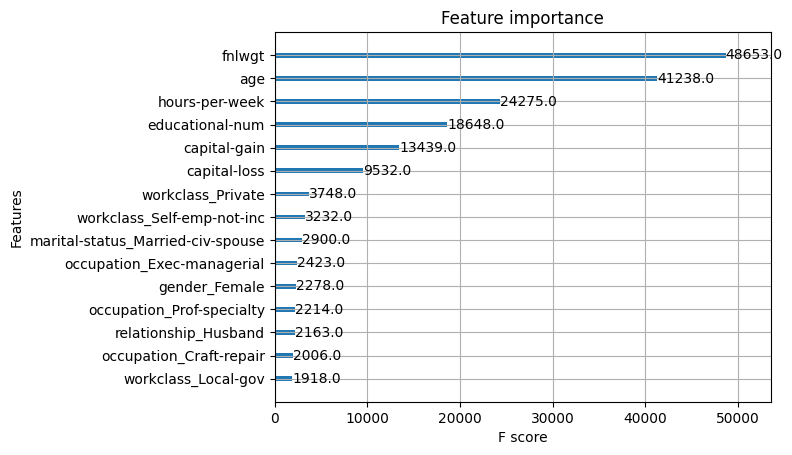

In [9]:
xgb.plot_importance(xgb2, max_num_features=15)

Looking at the resulting graph, we see that age dominates the other variables, clearly standing out as the most important predictor of income.
We could stop here and conclude with the intuitively satisfying answer that age is the most important variable, followed by hours worked per week and level of education.

Before we do, let's take a look at how the function works in the documentation: We can see that there are three options for measuring the importance of features in XGBoost:

'Weight' (default): the percentage representing the relative number of times a feature appears in the model's trees.
'Cover': The number of times a feature is used to separate data in the set of trees, weighted by the number of training data that pass through these separations.
'Gain': The average reduction in the loss function obtained when using a feature to separate a branch.
It is important to understand how these metrics work in order to interpret the results displayed.
For example, using 'Weight', it makes sense that a variable with a large number of possible values and that can be used a large number of times in a tree (such as age) should have a much greater importance than a binary variable that can only be used once in each tree (such as gender).
However, gender could be a feature that greatly affects the final results and be of great importance, based on 'Gain' or 'Cover'.

A higher value of the 'Gain' metric for one feature than for another implies that it is more important for generating a prediction.
It is therefore, for many, the most relevant metric for interpreting the relative importance of each feature.

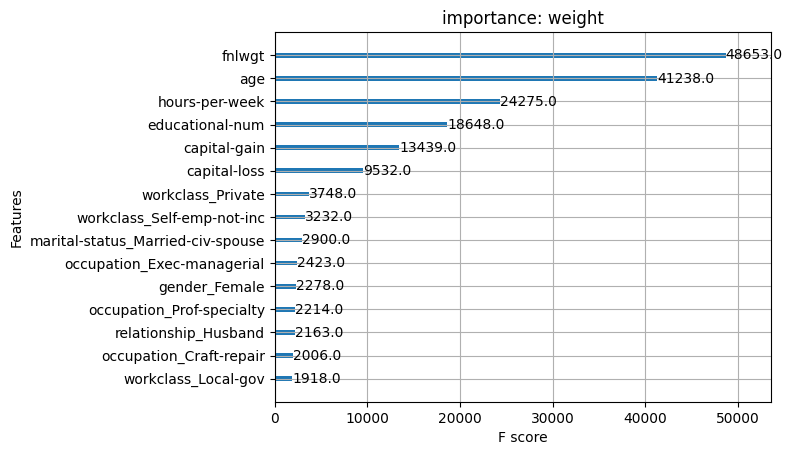

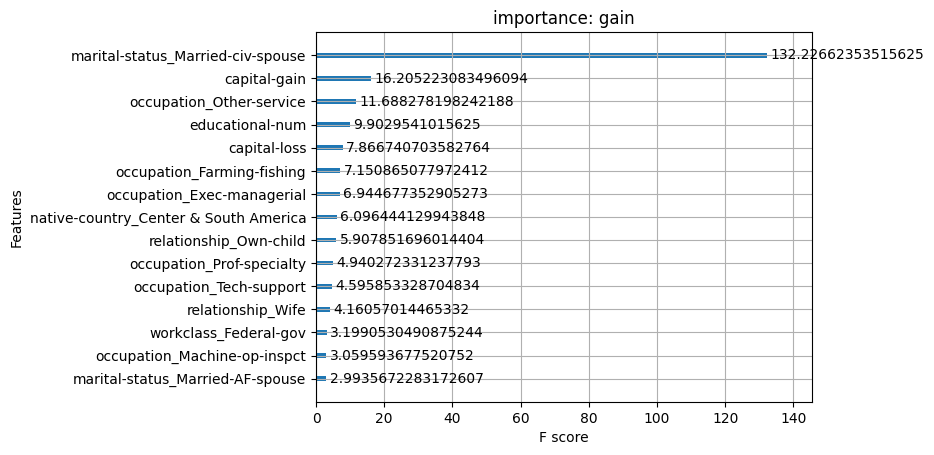

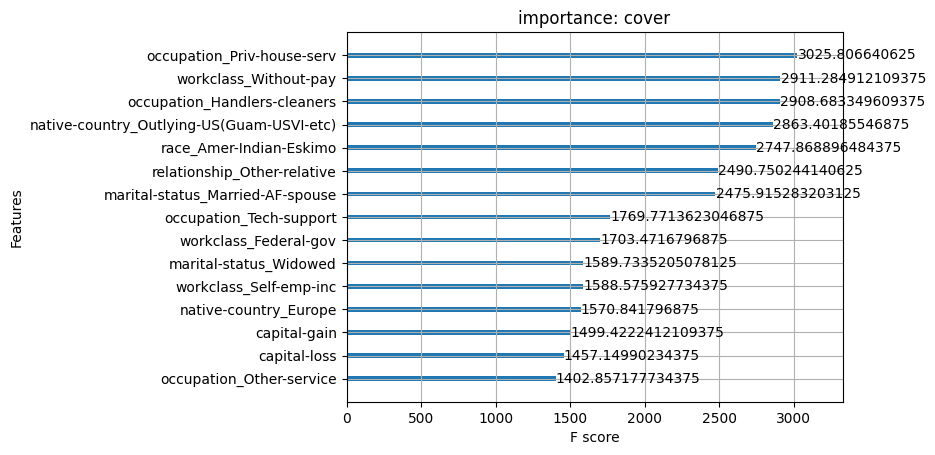

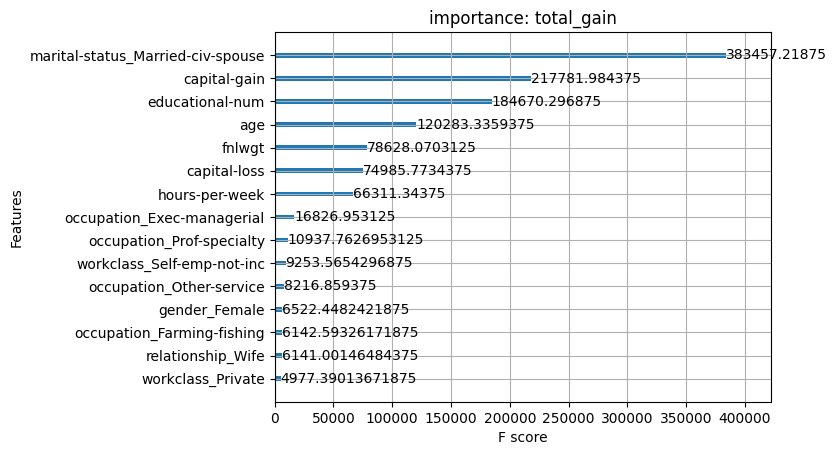

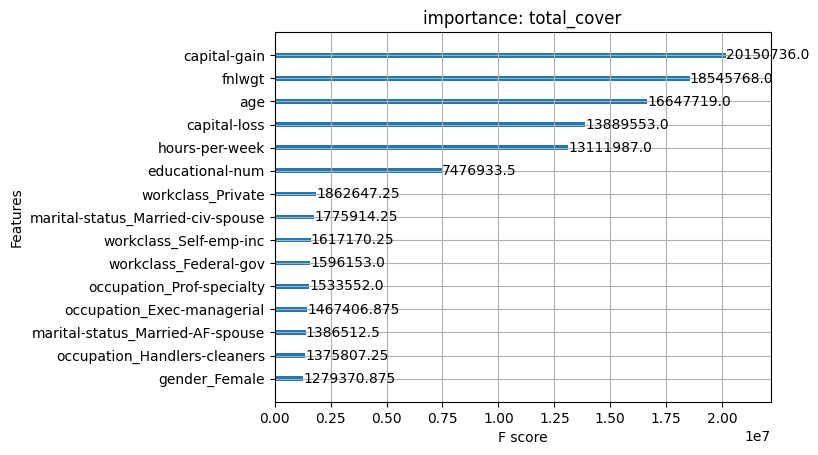

In [10]:
types= ['weight', 'gain', 'cover', 'total_gain', 'total_cover']

for f in types:
    xgb.plot_importance(xgb2 ,max_num_features=15, importance_type=f, title='importance: '+f)

In [11]:
bst_cv = xgb.cv(params=params,
                dtrain=train,
                num_boost_round=1000,
                nfold=3,
                early_stopping_rounds=60)
bst_cv

,train-logloss-mean,train-logloss-std,test-logloss-mean,test-logloss-std
0,0.545661,0.002105,0.545748,0.003678
1,0.541613,0.002122,0.541743,0.003665
2,0.537666,0.002138,0.537840,0.003651
3,0.533818,0.002155,0.534034,0.003642
4,0.530079,0.002187,0.530337,0.003612
...,...,...,...,...
995,0.248712,0.004067,0.277645,0.005008
996,0.248682,0.004074,0.277634,0.005005
997,0.248652,0.004066,0.277626,0.005003
998,0.248631,0.004067,0.277611,0.004997


In [12]:
preds = xgb2.predict(test)

xgbpreds = pd.Series(np.where(preds > 0.5, 1, 0))

pd.crosstab(xgbpreds, pd.Series(y_test))

col_0,0,1
row_0,,
0,6253,760
1,376,1403


In [13]:
xgb2.eval(valid)


'[0]\teval-logloss:0.28865810762173355'

The LCE (Local Cascade Ensemble) Machine Learning model is an ensemble method designed for building efficient predictors. It combines several diversification and learning techniques to improve predictive performance. The construction of an effective predictor is based on an ensemble method combining accurate and diversified individual predictors.

Two main diversification approaches are used:

Modify the distribution of the training data.
Learn different parts of the data.
The LCE model adopts both approaches by combining bagging and boosting, thus influencing the bias-variance trade-off, and using a "divide and conquer " strategy to learn different parts of the data.

The bias-variance trade-off defines the generalizability of the learning algorithm:

Sampling, via bagging, reduces variance.

Boosting reduces bias.
The LCE uses XGBoost as the basic learner for boosting, also incorporating bagging methods. It handles missing data and automatically adjusts its hyperparameters using Hyperopt sequential optimization.

The LCE method uses cascade generalization, adding new attributes at each step, and reduces bias using a boosted decision tree. Finally, it aggregates the predictions of the different predictors to obtain a final predictor.

In the rest of the exercise, we'll work again with the 'adult_income.csv' dataset, taking .
as our starting point. As a reminder, the last column 'income' is a binary variable taking the value '<=50k' if the individual earns less than 50000, and '>50k' if he earns more.
The income variable will be our target variable.

(a) Import LCEClassifier from lce.
(b) Import the accuracy_score function from sklearn.metrics.
(c) From features_matrix and target, create a training set containing 80% of the data with the train_test_split function.

In [20]:
from lce import LCEClassifier
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject